#Mount Drive + Load Libraries#

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461'

Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461


In [ ]:
# python libraries
import pandas as pd
import torch 
import torch.nn as nn
from datetime import date
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
import time
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#ANN Modeling#

In [ ]:
# Importing the data
data = pd.read_csv("processed/combined_ohe_17.csv")
edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

# making education binary
educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}

# # drop features
# data.drop(columns=['specedsv_No',
#  'specedsv_Yes',
#  'ilnasv_No',
#  'ilnasv_Yes',
#  'acsuppsv_No',
#  'acsuppsv_Yes',
#  'psedsuppsv_No',
#  'psedsuppsv_Yes',
#  'careersv_No',
#  'careersv_Yes',
#  'emplytrsv_No',
#  'emplytrsv_Yes',
#  'budgetsv_No',
#  'budgetsv_Yes',
#  'housedsv_No',
#  'housedsv_Yes',
#  'hlthedsv_No',
#  'hlthedsv_Yes',
#  'famsuppsv_No',
#  'famsuppsv_Yes',
#  'mentorsv_No',
#  'mentorsv_Yes',
#  'silsv_No',
#  'silsv_Yes',
#  'rmbrdfasv_No',
#  'rmbrdfasv_Yes',
#  'educfinasv_No',
#  'educfinasv_Yes',
#  'othrfinasv_No',
#  'othrfinasv_Yes'], axis=1, inplace=True)

data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

# dropping overlap variables (and other outcome features, recnumbr)
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'edu_binary','homeless_no','homeless_yes',
                   'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical',  'currpte_yes', 'currpte_no','currfte_yes', 
                   'currfte_no','age'], axis=1, inplace=True)

# filtering for age 19+ and balancing the class
#data = data[data['age']>18].sort_values('edu_binary').iloc[:1084*2,:]
target="subabuse_yes"
# Setting target variables
data = data.sample(frac=1)
y = data.loc[:,target]
X = data.loc[:,data.columns !=target]

# Feature scaling 
# scaler = MinMaxScaler((-1,1))
# X['age'] = scaler.fit_transform(np.array(X['age']).reshape(-1, 1))



In [ ]:
# OVER SAMPLING
# over = pd.DataFrame()
# for i in range(2):
#   over=over.append(data[data["subabuse_yes"] == 1])
# over=over.append(data[data["subabuse_yes"] == 1].iloc[:int(5980 /2),:])
# data=data.append(over).sample(frac=1)
smote_enn = SMOTEENN(random_state=0)
X, y = smote_enn.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
def my_cm_dec(y,y_pred):
  cm = confusion_matrix(y,y_pred)
  # print(cm.ravel())
  # print('(tn, fp, fn, tp)')
  n=sum(cm.ravel()[:2])
  p=sum(cm.ravel()[2:])
  cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
  cm_matrix = cm_matrix.loc[ ['Actual Positive:1','Actual Negative:0'], [ 'Predict Positive:1', 'Predict Negative:0']]
  cm_matrix.loc['Actual Positive:1', :] = cm_matrix.loc['Actual Positive:1', :] /p
  cm_matrix.loc['Actual Negative:0', :]  = cm_matrix.loc['Actual Negative:0', :] /n
  sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')
  plt.show()
  return cm.ravel()


In [ ]:
#data loader for torch
class data_class(torch.utils.data.Dataset):
  def __init__(self, X,y):
    self.x=torch.tensor(X.values,dtype=torch.float32)
    self.y=torch.tensor(y.values.reshape(-1,1),dtype=torch.float32)
  def __len__(self):
    return len(self.y)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]
train_loader=torch.utils.data.DataLoader(data_class(X_train,y_train),batch_size=128,shuffle=True)
test_loader=torch.utils.data.DataLoader(data_class(X_test,y_test), batch_size=128, shuffle=True)

Modeling 

In [ ]:
# viewing data loader
print("Number of training examples:", len(train_loader))
print("Number of testing examples:", len(test_loader))

# features in sample
examples = iter(train_loader)
samples, labels = next(examples)
print("Sample shape: ", samples.shape)
print("Label shape: ", labels.shape)


Number of training examples: 238
Number of testing examples: 60
Sample shape:  torch.Size([128, 141])
Label shape:  torch.Size([128, 1])


In [ ]:
# defining the model
class ANN(nn.Module):
  def __init__(self, input_size, num_classes):
    super(ANN, self).__init__()
    self.relu = nn.ReLU()
    self.input_layer = nn.Linear(input_size, 128)
    self.hidden1 = nn.Linear(128,64)
    self.hidden2 = nn.Linear(64,32)
    self.hidden3 = nn.Linear(32,16)
    self.hidden4 = nn.Linear(16,8)
    self.output_layer= nn.Linear(8,num_classes)
    self.activation = nn.Sigmoid()
    self.batch_norm = nn.BatchNorm1d(8)
  def forward(self, sample):
    out = self.input_layer(sample)
    out = self.relu(out)
    out = self.hidden1(out)
    out = self.relu(out)
    out = self.hidden2(out)
    out = self.relu(out)
    out = self.hidden3(out)
    out = self.relu(out)
    out = self.hidden4(out)
    out = self.relu(out)
    out = self.batch_norm(out)
    return self.activation(self.output_layer(out))
model = ANN(141, 1)
print(model)

ANN(
  (relu): ReLU()
  (input_layer): Linear(in_features=141, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (hidden4): Linear(in_features=16, out_features=8, bias=True)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
# define loss and optimizer
# loss_function = nn.functional.binary_cross_entropy_with_logits
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# training model
num_epochs = 10
total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (samples,labels) in enumerate (train_loader):
    samples = samples.to(device)
    labels = labels.to(device)

    output = model.forward(samples)
    loss = loss_function(output, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')

epoch 1 / 10, step 100/238, loss = 0.3889
epoch 1 / 10, step 200/238, loss = 0.3342
epoch 2 / 10, step 100/238, loss = 0.3834
epoch 2 / 10, step 200/238, loss = 0.3182
epoch 3 / 10, step 100/238, loss = 0.2669
epoch 3 / 10, step 200/238, loss = 0.3154
epoch 4 / 10, step 100/238, loss = 0.2397
epoch 4 / 10, step 200/238, loss = 0.3208
epoch 5 / 10, step 100/238, loss = 0.2347
epoch 5 / 10, step 200/238, loss = 0.3013
epoch 6 / 10, step 100/238, loss = 0.2584
epoch 6 / 10, step 200/238, loss = 0.3144
epoch 7 / 10, step 100/238, loss = 0.3518
epoch 7 / 10, step 200/238, loss = 0.2506
epoch 8 / 10, step 100/238, loss = 0.2530
epoch 8 / 10, step 200/238, loss = 0.2728
epoch 9 / 10, step 100/238, loss = 0.3222
epoch 9 / 10, step 200/238, loss = 0.2715
epoch 10 / 10, step 100/238, loss = 0.3036
epoch 10 / 10, step 200/238, loss = 0.1855


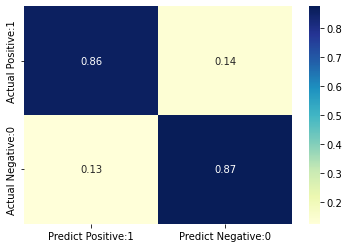

[2507  360  649 4070]


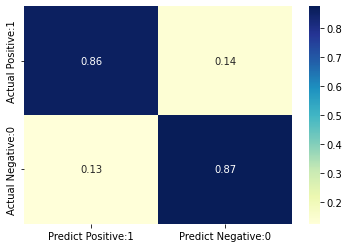

7586
Average Accuracy: 0.8695776973317657
Average Cost/Loss: 0.2968045473098755
Average F1 score:	0.8868594165540409
Average AUC score:	0.8543832699876943
Average Recall score:	0.9152477686708237
Average Precision score:	0.8620050447579589


In [ ]:
# test set, do not updatee gradients
with torch.no_grad():
  accuracy_arr=[]
  loss_arr=[]
  f1_arr = []
  recall_arr=[]
  precision_arr=[]
  labels_arr=[]
  predictions_arr=[]
  auc_arr=[]
  corr_num = 0
  sample_num=0

  for indiv, labels in test_loader:
    indiv =   indiv.to(device)
    labels = labels.to(device)
    #print(indiv)
    output = model(indiv)

    sample_num += labels.shape[0]
    predictions = torch.round(output)
    corr_num += (predictions == labels).sum().item()

    loss = loss_function(output, labels)
    loss_arr.append(loss)
    accuracy = corr_num / sample_num
    accuracy_arr.append(accuracy)

    f1 = f1_score(predictions, labels, labels=labels)
    f1_arr.append(f1)
    recall = recall_score(predictions, labels, labels=labels)
    precision = precision_score(predictions, labels, labels=labels)
    auc = roc_auc_score(predictions, labels, labels=labels)
    recall_arr.append(recall)
    precision_arr.append(precision)
    auc_arr.append(auc)
    labels_arr += labels.tolist()
    predictions_arr += predictions.tolist()

print(my_cm_dec(labels_arr, predictions_arr))
print(sum(my_cm_dec(labels_arr, predictions_arr)))

print(f'Average Accuracy: {sum(accuracy_arr)/len(accuracy_arr)}')
print(f'Average Cost/Loss: {sum(loss_arr)/len(loss_arr)}')
print(f'Average F1 score:\t{np.average(np.array(f1_arr))}')
print(f'Average AUC score:\t{np.average(np.array(auc_arr))}')
print(f'Average Recall score:\t{np.average(np.array(recall_arr))}')
print(f'Average Precision score:\t{np.average(np.array(precision_arr))}')


Cross Validation

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
def stdev(test_list):
  mean = sum(test_list) / len(test_list)
  return (sum([((x - mean) ** 2) for x in test_list]) / len(test_list)) ** 0.5

Reset trainable parameters of layer = Linear(in_features=141, out_features=128, bias=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=8, bias=True)
Reset trainable parameters of layer = Linear(in_features=8, out_features=1, bias=True)
Reset trainable parameters of layer = BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
epoch 1 / 10, step 100/238, loss = 0.4917
epoch 1 / 10, step 200/238, loss = 0.4655
epoch 2 / 10, step 100/238, loss = 0.3911
epoch 2 / 10, step 200/238, loss = 0.4018
epoch 3 / 10, step 100/238, loss = 0.3182
epoch 3 / 10, step 200/238, loss = 0.3017
epoch 4 / 10, step 100/238, loss = 0.3045
epoch 4 / 10, step 200/238, loss = 0.2439
epoch 5 / 10,

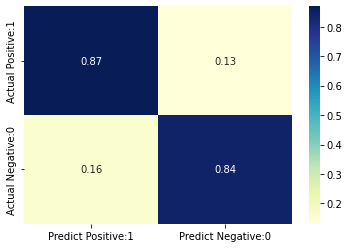

[122271  23229  30613 203147]
Average Accuracy: 0.8575186396503683
Average Cost/Loss: 0.32156699895858765
Average F1 score:	0.8826778424803652
Average AUC score:	0.8495001793237804
Average Recall score:	0.8986378717296493
Average Precision score:	nan
0.034862167991021535
0.029144312418924852
TIME: 1.0982844058166676 min


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
start = time.perf_counter()
loss_function = nn.BCELoss()

num_batch = 128
num_epochs = 10
accuracy_arr=[]
loss_arr=[]
f1_arr = []
recall_arr=[]
precision_arr=[]
labels_arr=[]
predictions_arr=[]
f1_fold=[]
auc_arr=[]
for train_index, test_index in kfold.split(X,y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  train_loader=torch.utils.data.DataLoader(data_class(X_train,y_train),batch_size=num_batch,shuffle=True)
  test_loader=torch.utils.data.DataLoader(data_class(X_test,y_test), batch_size=num_batch, shuffle=True)
  model = ANN(141, 1)
  model.to(device)
  model.apply(reset_weights)
  optimizer = torch.optim.Adam(model.parameters())
  for epoch in range(num_epochs):
    for i, (samples,labels) in enumerate (train_loader):
      samples = samples.to(device)
      labels = labels.to(device)

      output = model.forward(samples)
      loss = loss_function(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 100 == 0:
        print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')
      
    with torch.no_grad():
      corr_num = 0
      sample_num=0

      for indiv, labels in test_loader:
        indiv =   indiv.to(device)
        labels = labels.to(device)
        
        output = model(indiv)

        sample_num += labels.shape[0]
        predictions = torch.round(output)
        corr_num += (predictions == labels).sum().item()



        loss = loss_function(output, labels)
        loss_arr.append(loss)
        accuracy = corr_num / sample_num
        accuracy_arr.append(accuracy)

        f1 = f1_score(predictions, labels, labels=labels)
        f1_arr.append(f1)
        recall = recall_score(predictions, labels, labels=labels)
        #precision = precision_score(predictions, labels, labels=labels)
        auc=roc_auc_score(predictions, labels, labels=labels)
        f1_arr.append(f1)
        auc_arr.append(auc)
        recall_arr.append(recall)
        #precision_arr.append(precision)
        labels_arr += labels.tolist()
        predictions_arr += predictions.tolist()
    #print(my_cm_dec(labels_arr, predictions_arr))
print(my_cm_dec(labels_arr, predictions_arr))

print(f'Average Accuracy: {sum(accuracy_arr)/len(accuracy_arr)}')
print(f'Average Cost/Loss: {sum(loss_arr)/len(loss_arr)}')
print(f'Average F1 score:\t{np.average(np.array(f1_arr))}')
print(f'Average AUC score:\t{np.average(np.array(auc_arr))}')
print(f'Average Recall score:\t{np.average(np.array(recall_arr))}')
print(f'Average Precision score:\t{np.average(np.array(precision_arr))}')
print(stdev(auc_arr))
print(stdev(f1_arr))
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

In [ ]:
labels=np.array(labels_arr).flatten()
predictions=np.array(predictions_arr).flatten()

In [ ]:
state=data[["st_AK",
"st_AL",
"st_AR",
"st_AZ",
"st_CA",
"st_CO",
"st_CT",
"st_DC",
"st_DE",
"st_FL",
"st_GA",
"st_HI",
"st_IA",
"st_ID",
"st_IL",
"st_IN",
"st_KS",
"st_KY",
"st_LA",
"st_MA",
"st_MD",
"st_ME",
"st_MI",
"st_MN",
"st_MO",
"st_MS",
"st_MT",
"st_NC",
"st_ND",
"st_NE",
"st_NH",
"st_NJ",
"st_NM",
"st_NV",
"st_NY",
"st_OH",
"st_OK",
"st_OR",
"st_PA",
"st_PR",
"st_RI",
"st_SC",
"st_SD",
"st_TN",
"st_TX",
"st_UT",
"st_VA",
"st_VT",
"st_WA",
"st_WI",
"st_WV",
"st_WY"]].idxmax(axis=1)

mapping={"st_AK":"West",
"st_AZ":"West",
"st_CA":"West",
"st_CO":"West",
"st_HI":"West",
"st_ID":"West",
"st_MT":"West",
"st_NM":"West",
"st_NV":"West",
"st_OR":"West",
"st_UT":"West",
"st_WA":"West",
"st_WY":"West",
"st_AL":"South",
"st_AR":"South",
"st_DC":"South",
"st_DE":"South",
"st_FL":"South",
"st_GA":"South",
"st_KY":"South",
"st_LA":"South",
"st_MD":"South",
"st_MS":"South",
"st_NC":"South",
"st_OK":"South",
"st_PR":"South",
"st_SC":"South",
"st_TN":"South",
"st_TX":"South",
"st_VA":"South",
"st_WV":"South",
"st_CT":"Northeast",
"st_ME":"Northeast",
"st_MA":"Northeast",
"st_NH":"Northeast",
"st_NJ":"Northeast",
"st_NY":"Northeast",
"st_PA":"Northeast",
"st_RI":"Northeast",
"st_VT":"Northeast",
"st_IA":"Midwest",
"st_IL":"Midwest",
"st_IN":"Midwest",
"st_KS":"Midwest",
"st_MI":"Midwest",
"st_MN":"Midwest",
"st_MO":"Midwest",
"st_ND":"Midwest",
"st_NE":"Midwest",
"st_OH":"Midwest",
"st_SD":"Midwest",
"st_WI":"Midwest"
}
region =state.map(mapping)

Female by Percenct


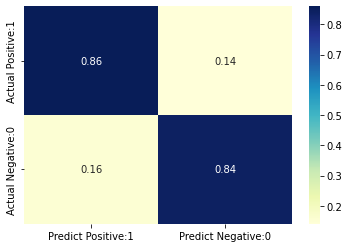

[5882 1079 1577 9668]
Male by Percenct


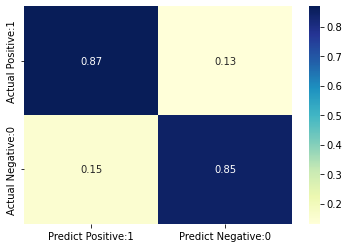

[5797 1059 1431 9449]
Breakdown by South


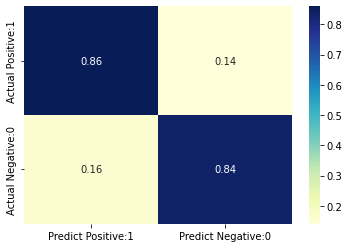

[5464 1055 1459 8896]
Breakdown by Midwest


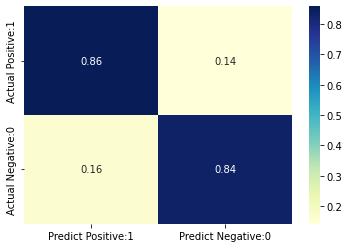

[3406  659  942 5733]
Breakdown by Northeast


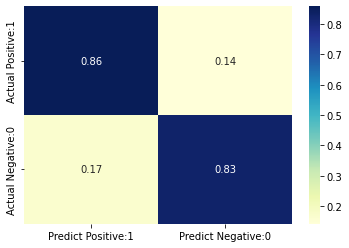

[2157  438  566 3416]
Breakdown by West


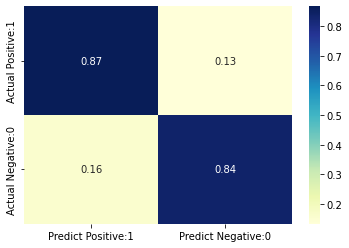

[3584  689  916 5984]
Breakdown by white
YES - By percent


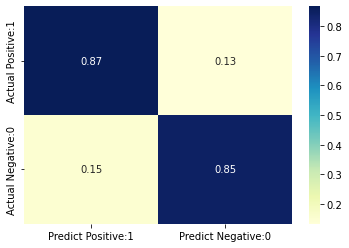

[ 8017  1452  2051 13259]
NO - by percent


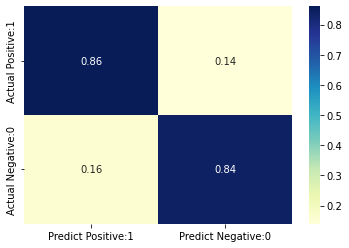

[4042  754 1057 6500]
Breakdown by blkafram
YES - By percent


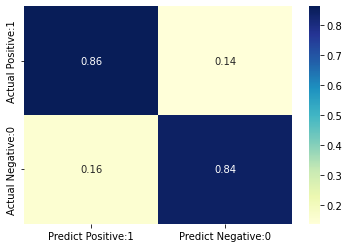

[3903  720 1006 6243]
NO - by percent


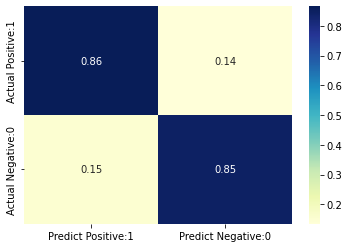

[ 8143  1486  2097 13434]


In [ ]:
print("Female by Percenct")

print(my_cm_dec(labels[X.index[X['sex_female'] == True].tolist()],predictions[X.index[X['sex_female'] == True].tolist()]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(labels[X.index[X['sex_male'] == True].tolist()],predictions[X.index[X['sex_male'] == True].tolist()]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(labels[region.index[region == i]], predictions[region.index[region == i]]))
  plt.show()

for i in ['white', 'blkafram']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(labels[X.index[X[i+'_yes']==True].tolist()],predictions[X.index[X[i+'_yes'] == True].tolist()]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(labels[X.index[X[i+'_no'] == True].tolist()],predictions[X.index[X[i+'_no'] == True].tolist()]))
  plt.show()